## Data Handling

Install and import dependencies

In [1]:
%%capture

# Import necessary libraries
!pip install git+https://github.com/daviddavo/lightfm
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
# Load individual files
df_category = pd.read_csv('/content/drive/MyDrive/Azubi data analytics projects/TMP/category_tree.csv')
df_events = pd.read_csv('/content/drive/MyDrive/Azubi data analytics projects/TMP/events.csv')
df_items_one = pd.read_csv('/content/drive/MyDrive/Azubi data analytics projects/TMP/item_properties_part1.1.csv')
df_items_two = pd.read_csv('/content/drive/MyDrive/Azubi data analytics projects/TMP/item_properties_part2.csv')

print(df_category.shape)
print(df_events.shape)
print(df_items_one.shape)
print(df_items_two.shape)

(1669, 2)
(2756101, 5)
(10999999, 4)
(9275903, 4)


In [3]:
# Inspect columns
print(df_items_two.columns)
print(df_category.columns)
print(df_events.columns)

Index(['timestamp', 'itemid', 'property', 'value'], dtype='object')
Index(['categoryid', 'parentid'], dtype='object')
Index(['timestamp', 'visitorid', 'event', 'itemid', 'transactionid'], dtype='object')


In [4]:
# Combining item files
df_items_append = pd.concat([df_items_one, df_items_two], ignore_index=True)
df_items_append.shape

(20275902, 4)

In [5]:
# Remove duplicates
df_events = df_events.drop_duplicates()
df_items_append = df_items_append.drop_duplicates()
df_category = df_category.drop_duplicates()

Data manipulation

In [6]:
# Convert timestamp to datetime
df_events['timestamp'] = pd.to_datetime(df_events['timestamp'], unit='ms')
df_items_append['timestamp'] = pd.to_datetime(df_items_append['timestamp'], unit='ms')

display(df_events.head())
display(df_items_append.head())

,timestamp,visitorid,event,itemid,transactionid
0,2015-06-02 05:02:12.117,257597,view,355908,NaN
1,2015-06-02 05:50:14.164,992329,view,248676,NaN
2,2015-06-02 05:13:19.827,111016,view,318965,NaN
3,2015-06-02 05:12:35.914,483717,view,253185,NaN
4,2015-06-02 05:02:17.106,951259,view,367447,NaN


,timestamp,itemid,property,value
0,2015-06-28 03:00:00,460429,categoryid,1338
1,2015-09-06 03:00:00,206783,888,1116713 960601 n277.200
2,2015-08-09 03:00:00,395014,400,n552.000 639502 n720.000 424566
3,2015-05-10 03:00:00,59481,790,n15360.000
4,2015-05-17 03:00:00,156781,917,828513


Splitting data into smaller-workable formats

In [7]:
available_df = df_items_append[df_items_append['property']=='available']
hashed_df = df_items_append[~((df_items_append['property']=='available')|(df_items_append['property']=='categoryid'))]
transactionevent_df = df_events[df_events['event']=='transaction']

display(available_df.head())
display(hashed_df.head())
display(transactionevent_df.head())

,timestamp,itemid,property,value
5,2015-07-05 03:00:00,285026,available,0
15,2015-07-19 03:00:00,186518,available,0
79,2015-06-07 03:00:00,423682,available,0
82,2015-06-14 03:00:00,316253,available,1
96,2015-07-19 03:00:00,430459,available,0


,timestamp,itemid,property,value
1,2015-09-06 03:00:00,206783,888,1116713 960601 n277.200
2,2015-08-09 03:00:00,395014,400,n552.000 639502 n720.000 424566
3,2015-05-10 03:00:00,59481,790,n15360.000
4,2015-05-17 03:00:00,156781,917,828513
6,2015-06-14 03:00:00,89534,213,1121373


,timestamp,visitorid,event,itemid,transactionid
130,2015-06-02 05:17:56.276,599528,transaction,356475,4000.0
304,2015-06-01 21:18:20.981,121688,transaction,15335,11117.0
418,2015-06-01 21:25:15.008,552148,transaction,81345,5444.0
814,2015-06-01 16:38:56.375,102019,transaction,150318,13556.0
843,2015-06-01 16:01:58.180,189384,transaction,310791,7244.0


In [8]:
categoryid_df = df_items_append[df_items_append['property']=='categoryid']
categoryid_df = categoryid_df[['timestamp', 'itemid', 'value']]

# Rename column
categoryid_df = categoryid_df.rename(columns={"value":"categoryid"})

# Change datatype of categoryid column for data merge
categoryid_df['categoryid']= categoryid_df['categoryid'].astype('int64')

# Merge dataframes on categoryid
categoryid_df = categoryid_df.merge(df_category, on='categoryid', how='left')
categoryid_df.head()


,timestamp,itemid,categoryid,parentid
0,2015-06-28 03:00:00,460429,1338,1278.0
1,2015-05-24 03:00:00,281245,1277,312.0
2,2015-06-28 03:00:00,35575,1059,1696.0
3,2015-07-19 03:00:00,8313,1147,1027.0
4,2015-07-26 03:00:00,55102,47,381.0


In [9]:
viewevent_df = df_events[df_events['event']=='view']
viewevent_df = viewevent_df[['timestamp', 'visitorid', 'event', 'itemid']]

addtocart_df = df_events[df_events['event']=='addtocart']
addtocart_df = addtocart_df[['timestamp', 'visitorid', 'event', 'itemid']]

display(viewevent_df.head())
display(addtocart_df.head())

,timestamp,visitorid,event,itemid
0,2015-06-02 05:02:12.117,257597,view,355908
1,2015-06-02 05:50:14.164,992329,view,248676
2,2015-06-02 05:13:19.827,111016,view,318965
3,2015-06-02 05:12:35.914,483717,view,253185
4,2015-06-02 05:02:17.106,951259,view,367447


,timestamp,visitorid,event,itemid
17,2015-06-02 05:33:56.124,287857,addtocart,5206
19,2015-06-02 04:57:58.505,158090,addtocart,10572
63,2015-06-02 05:39:03.021,1193904,addtocart,255275
112,2015-06-02 05:12:21.632,599528,addtocart,356475
179,2015-06-02 04:54:40.956,105775,addtocart,312728


### Data Exploration

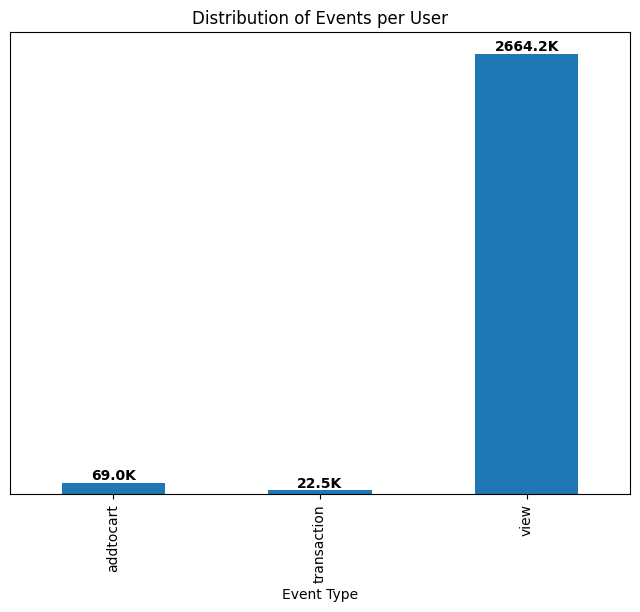

In [10]:
ax = df_events.groupby('event')['visitorid'].count().plot(kind='bar', figsize=(8,6))

# Title and labels
plt.title("Distribution of Events per User")
plt.xlabel("Event Type")
plt.ylabel("")  # Remove y-axis label

# Remove y-axis ticks
ax.yaxis.set_visible(False)

# Add value labels in millions
for p in ax.patches:
    value_millions = p.get_height() / 1_000
    ax.annotate(f'{value_millions:.1f}K',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.show()


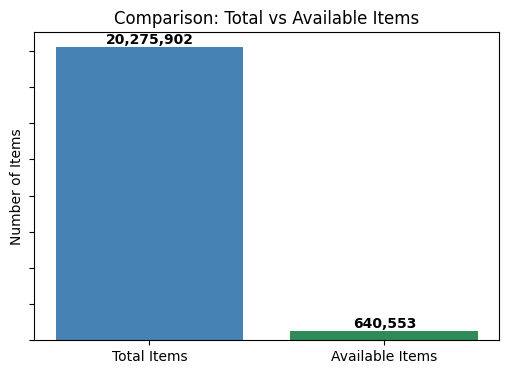

In [11]:
# total items
total_items = len(df_items_append.drop_duplicates())

# available items
available_items = len(available_df[available_df["value"]=="1"])

# put into a DataFrame for easier plotting
counts_df = pd.DataFrame({
    "Category": ["Total Items", "Available Items"],
    "Count": [total_items, available_items]
})

# plot side-by-side
plt.figure(figsize=(6,4))
bars = plt.bar(counts_df["Category"], counts_df["Count"], color=["steelblue", "seagreen"])

# add value labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f"{height:,}",
             ha="center", va="bottom", fontsize=10, fontweight="bold")

plt.title("Comparison: Total vs Available Items")
plt.ylabel("Number of Items")
plt.tick_params(axis='y', labelleft=False)
plt.show()


In [12]:
# Number of individual users

df_events['visitorid'].nunique()

1407580

Bot detection

In [13]:
max_count = df_events.groupby('visitorid')['itemid'].count().max()
max_visitor = df_events.groupby('visitorid')['itemid'].count().idxmax()

print("Visitor with highest itemid count:", max_visitor)
print("Count:", max_count)


Visitor with highest itemid count: 1150086
Count: 7757


In [14]:
top_30_users = (
    df_events.groupby('visitorid')['itemid']
    .count()
    .sort_values(ascending=False)
    .head(30)
)

print(top_30_users)


visitorid
1150086    7757
530559     4328
152963     3024
895999     2474
163561     2410
371606     2345
286616     2252
684514     2246
892013     2024
861299     1991
836635     1934
76757      1883
638482     1829
1297062    1822
316850     1752
247235     1698
1161163    1663
994820     1661
79627      1623
518659     1613
138131     1611
350566     1524
85734      1461
645525     1411
765630     1277
757355     1251
310759     1177
229157     1070
737053     1055
890980     1017
Name: itemid, dtype: int64


Top 10 Users

In [15]:
user_activity = pd.pivot_table(df_events, columns='event', index='visitorid',values='itemid', aggfunc='count')
user_activity = user_activity.fillna(0)
user_activity['score'] = user_activity['addtocart'] + user_activity['transaction']+user_activity['view']
top_users = user_activity.sort_values('score', ascending=False).head(10)
display(top_users)

event,addtocart,transaction,view,score
visitorid,,,,
1150086,719.0,559.0,6479.0,7757.0
530559,419.0,286.0,3623.0,4328.0
152963,371.0,349.0,2304.0,3024.0
895999,56.0,50.0,2368.0,2474.0
163561,124.0,92.0,2194.0,2410.0
371606,110.0,94.0,2141.0,2345.0
286616,120.0,75.0,2057.0,2252.0
684514,231.0,189.0,1826.0,2246.0
892013,1.0,0.0,2023.0,2024.0


Top 10 Items

In [16]:
item_popularity = df_events.groupby(['itemid','event']).size().unstack(fill_value=0)
item_popularity['score'] = item_popularity['addtocart'] + item_popularity['transaction']+item_popularity['view']
item_popularity = item_popularity.sort_values('score', ascending=False).head(10)
print(item_popularity)

event   addtocart  transaction  view  score
itemid                                     
187946          2            0  3410   3412
461686        304          133  2538   2975
5411            9            0  2325   2334
370653          0            0  1854   1854
219512         48           12  1740   1800
257040         89           27  1531   1647
298009          0            0  1642   1642
96924           0            0  1633   1633
309778         48           15  1565   1628
384302         65           15  1528   1608


In [17]:
item_popularity['conversion_rate'] = (item_popularity['transaction'] / item_popularity['view'])#.replace(0,1)
top_conversions = item_popularity.sort_values('conversion_rate', ascending=False).head(10)
print(top_conversions)


event   addtocart  transaction  view  score  conversion_rate
itemid                                                      
461686        304          133  2538   2975         0.052403
257040         89           27  1531   1647         0.017636
384302         65           15  1528   1608         0.009817
309778         48           15  1565   1628         0.009585
219512         48           12  1740   1800         0.006897
187946          2            0  3410   3412         0.000000
5411            9            0  2325   2334         0.000000
370653          0            0  1854   1854         0.000000
96924           0            0  1633   1633         0.000000
298009          0            0  1642   1642         0.000000


Top 10 Parent/ Categories

In [18]:
df_with_cat = df_events.merge(df_category, left_on='itemid', right_on='categoryid', how='left')

category_stats = df_with_cat.groupby(['parentid','event']).size().unstack(fill_value=0)
category_stats['score'] = category_stats['addtocart'] + category_stats['transaction']+category_stats['view']
print(category_stats.sort_values('view', ascending=False).head(10))

event     addtocart  transaction  view  score
parentid                                     
679.0            30            7   695    732
250.0            46           23   658    727
1009.0            5            2   387    394
1687.0            3            1   280    284
1691.0            7            2   241    250
1518.0           19            5   239    263
893.0             5            2   147    154
587.0             8            2   145    155
1482.0            9            1   136    146
1600.0            9            6   112    127


In [19]:
category_stats_2 = df_with_cat.groupby(['categoryid','event']).size().unstack(fill_value=0)
category_stats_2['score'] = category_stats_2['addtocart'] + category_stats_2['transaction']+category_stats_2['view']
print(category_stats_2.sort_values('view', ascending=False).head(10))

event       addtocart  transaction  view  score
categoryid                                     
869.0              30            7   654    691
546.0              45           23   589    657
829.0              19            5   239    263
1152.0              7            2   238    247
1489.0              0            0   186    186
403.0               3            1   128    132
1255.0              8            2   125    135
496.0               5            2   124    131
534.0               0            0    97     97
1423.0              2            2    95     99


Periodic sessions

/tmp/ipython-input-2362642582.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transactionevent_df.loc[:, 'month'] = transactionevent_df['timestamp'].dt.month_name()


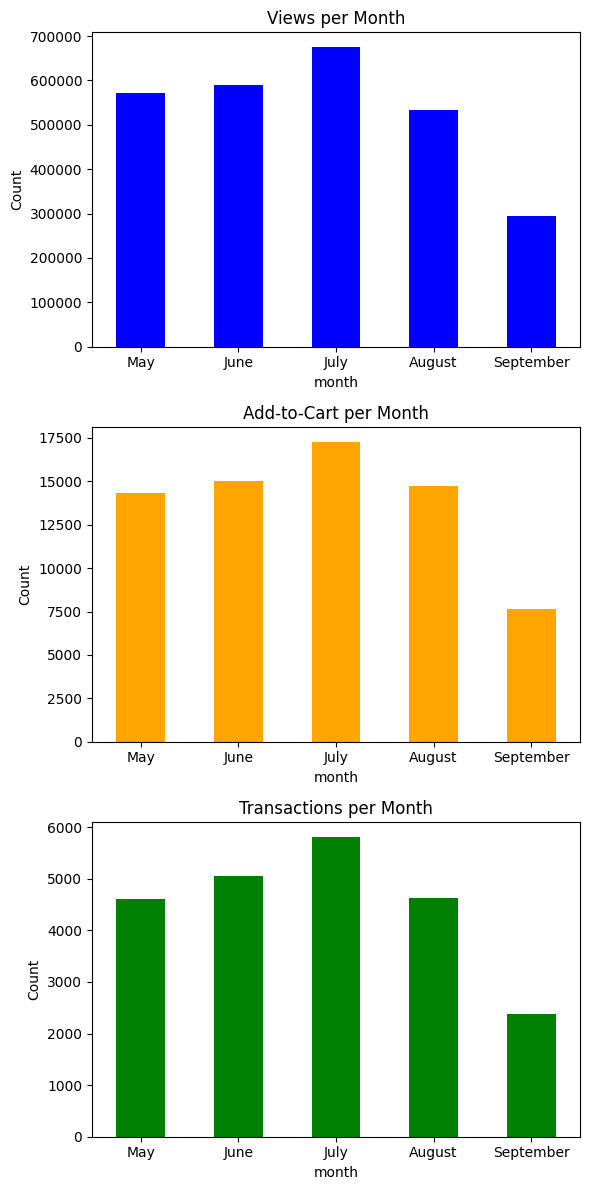

In [20]:
# Add month name columns
viewevent_df.loc[:, 'month'] = viewevent_df['timestamp'].dt.month_name()
addtocart_df.loc[:, 'month'] = addtocart_df['timestamp'].dt.month_name()
transactionevent_df.loc[:, 'month'] = transactionevent_df['timestamp'].dt.month_name()

# Ensure proper month order
months_order = ['May','June','July','August','September']

fig, axes = plt.subplots(3, 1, figsize=(6, 12))

# Views
view_counts = viewevent_df.groupby('month')['itemid'].count().reindex(months_order)
view_counts.plot(kind='bar', ax=axes[0], color='blue', legend=False)
axes[0].set_title("Views per Month")
axes[0].set_ylabel("Count")
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0) # Rotate x-axis labels

# Add-to-cart
cart_counts = addtocart_df.groupby('month')['itemid'].count().reindex(months_order)
cart_counts.plot(kind='bar', ax=axes[1], color='orange', legend=False)
axes[1].set_title("Add-to-Cart per Month")
axes[1].set_ylabel("Count")
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0) # Rotate x-axis labels

# Transactions
txn_counts = transactionevent_df.groupby('month')['itemid'].count().reindex(months_order)
txn_counts.plot(kind='bar', ax=axes[2], color='green', legend=False)
axes[2].set_title("Transactions per Month")
axes[2].set_ylabel("Count")
axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=0) # Rotate x-axis labels


plt.tight_layout()
plt.show()

/tmp/ipython-input-1658940512.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transactionevent_df.loc[:, 'day'] = transactionevent_df['timestamp'].dt.day_name()


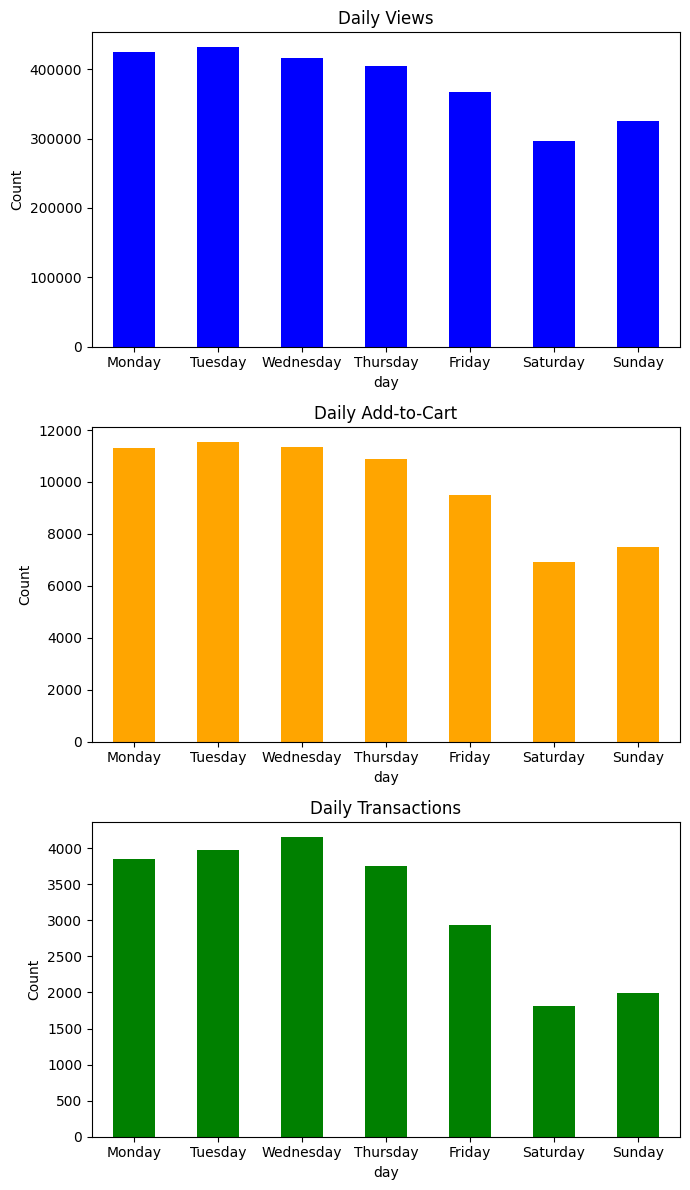

In [21]:
# Add month name columns
viewevent_df.loc[:, 'day'] = viewevent_df['timestamp'].dt.day_name()
addtocart_df.loc[:, 'day'] = addtocart_df['timestamp'].dt.day_name()
transactionevent_df.loc[:, 'day'] = transactionevent_df['timestamp'].dt.day_name()

# Ensure proper month order
daily_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

fig, axes = plt.subplots(3, 1, figsize=(7, 12))

# Views
view_counts = viewevent_df.groupby('day')['itemid'].count().reindex(daily_order)
view_counts.plot(kind='bar', ax=axes[0], color='blue', legend=False)
axes[0].set_title("Daily Views")
axes[0].set_ylabel("Count")
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0) # Rotate x-axis labels

# Add-to-cart
cart_counts = addtocart_df.groupby('day')['itemid'].count().reindex(daily_order)
cart_counts.plot(kind='bar', ax=axes[1], color='orange', legend=False)
axes[1].set_title("Daily Add-to-Cart")
axes[1].set_ylabel("Count")
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0) # Rotate x-axis labels

# Transactions
txn_counts = transactionevent_df.groupby('day')['itemid'].count().reindex(daily_order)
txn_counts.plot(kind='bar', ax=axes[2], color='green', legend=False)
axes[2].set_title("Daily Transactions")
axes[2].set_ylabel("Count")
axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=0) # Rotate x-axis labels


plt.tight_layout()
plt.show()

Time-based behavior

Most interactions happened in July.

Views & Add-to-Cart peak on Tuesday, while Transactions peak on Wednesday.

Availability

In [22]:
if 'available_df' in locals():
    available_items = set(available_df['itemid'])
    interacted_items = set(df_events['itemid'])
    unavailable_popular = interacted_items - available_items
    print("Popular but unavailable items:", list(unavailable_popular)[:10])


Popular but unavailable items: [262144, 131073, 131077, 393221, 9, 131087, 262161, 131090, 131091, 262171]


In [23]:
hashed_df.iloc[:20,:]

,timestamp,itemid,property,value
1,2015-09-06 03:00:00,206783,888,1116713 960601 n277.200
2,2015-08-09 03:00:00,395014,400,n552.000 639502 n720.000 424566
3,2015-05-10 03:00:00,59481,790,n15360.000
4,2015-05-17 03:00:00,156781,917,828513
6,2015-06-14 03:00:00,89534,213,1121373
7,2015-05-17 03:00:00,264312,6,319724
8,2015-06-07 03:00:00,229370,202,1330310
9,2015-06-14 03:00:00,98113,451,1141052 n48.000
10,2015-08-09 03:00:00,450113,888,1038400 45956 n504.000
11,2015-06-28 03:00:00,244127,400,n552.000 639502 n720.000 424566


In [24]:
pd.pivot_table(hashed_df.iloc[:20,1:], columns='itemid', index='property', aggfunc='count', fill_value=0)

value                                                          \
itemid   48696  49337  59481  89534  98113  156781 169055 178601 206783   
property                                                                  
0             0      1      0      0      0      0      0      0      0   
1022          0      0      0      0      0      0      0      0      0   
159           0      0      0      0      0      0      0      0      0   
202           0      0      0      0      0      0      0      0      0   
213           0      0      0      1      0      0      0      0      0   
227           0      0      0      0      0      0      0      0      0   
400           0      0      0      0      0      0      0      0      0   
451           0      0      0      0      1      0      0      0      0   
566           1      0      0      0      0      0      0      0      0   
6             0      0      0      0      0      0      0      0      0   
790           0      0      1      0      0      0      1      1      0   
839           0      0      0      0      0      0      0      0      0   
888           0      0      0      0      0      0      0      0      1   
917           0      0      0      0      0      1      0      0      0   

                                                                         \
itemid   229370 244127 264312 264319 269797 319291 344365 348323 363598   
property                                                                  
0             0      0      0      0      0      0      0      0      0   
1022          0      0      0      0      0      0      0      0      1   
159           0      0      0      0      1      0      1      0      0   
202           1      0      0      0      0      0      0      0      0   
213           0      0      0      0      0      0      0      0      0   
227           0      0      0      1      0      0      0      0      0   
400           0      1      0      0      0      0      0      0      0   
451           0      0      0      0      0      0      0      0      0   
566           0      0      0      0      0      0      0      0      0   
6             0      0      1      0      0      0      0      0      0   
790           0      0      0      0      0      0      0      0      0   
839           0      0      0      0      0      0      0      1      0   
888           0      0      0      0      0      1      0      0      0   
917           0      0      0      0      0      0      0      0      0   

                        
itemid   395014 450113  
property                
0             0      0  
1022          0      0  
159           0      0  
202           0      0  
213           0      0  
227           0      0  
400           1      0  
451           0      0  
566           0      0  
6             0      0  
790           0      0  
839           0      0  
888           0      1  
917           0      0

Considerations


---


1. Build weighted user-item matrix → views=1, cart=2, purchases=3.

2. Train collaborative filtering (ALS / implicit) → get CF scores.

3. Apply post-filters → exclude purchased/cart, unavailable items.

4. Blend with popularity score → trending by category/parent category.

5. Handle cold-start → global/top categories fallback.

6. Inject serendipity → 1 “exploration” item in top-5.

7. Adjust with recency weights → boost newer interactions.

## Sparse-item based collaborative filtering

* Sparse: Uses a csr_matrix to store only non-zero interactions (user viewed/added/purchased an item).

* Item-based: Computes similarities between items based on which users interacted with them.

* Collaborative: Recommendations are generated using user behavior patterns, not item metadata.

In [25]:
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity

In [26]:
# ============================
# 1) Assign weights to events
# ============================
viewevent_df = viewevent_df.copy()
addtocart_df = addtocart_df.copy()
transactionevent_df = transactionevent_df.copy()

viewevent_df["weight"] = 1
addtocart_df["weight"] = 2
transactionevent_df["weight"] = 3

# Keep only necessary columns
viewevent_df = viewevent_df[["visitorid", "itemid", "weight", "timestamp"]]
addtocart_df = addtocart_df[["visitorid", "itemid", "weight", "timestamp"]]
transactionevent_df = transactionevent_df[["visitorid", "itemid", "weight", "timestamp"]]

# Merge all events
interactions_df = pd.concat([viewevent_df, addtocart_df, transactionevent_df])

# Merge on only available products to decrease data size
check_available_df_2 = available_df[available_df["value"]=="1"]
interactions_df = interactions_df.merge(check_available_df_2, on="itemid", how="inner")
interactions_df = interactions_df.drop('timestamp_y', axis=1).rename(columns={"timestamp_x":"timestamp"})
interactions_df = interactions_df.drop_duplicates()


In [27]:
# ============================
# 2) Train-test split
# ============================
def fast_train_test_split(df, user_col="visitorid", test_size=0.2, seed=42):
    np.random.seed(seed)
    df = df.sample(frac=1, random_state=seed).reset_index(drop=True)
    user_counts = df.groupby(user_col).size()
    test_sizes = (user_counts * test_size).round().astype(int)
    cum_counts = user_counts.cumsum().shift(fill_value=0)
    test_idx = []
    for uid, n_test in test_sizes.items():
        if n_test == 0:
            continue
        start = cum_counts[uid]
        end = start + user_counts[uid]
        test_idx.extend(np.random.choice(np.arange(start, end), size=n_test, replace=False))
    mask = np.zeros(len(df), dtype=bool)
    mask[test_idx] = True
    df_train = df[~mask]
    df_test = df[mask]
    return df_train, df_test

df_train, df_test = fast_train_test_split(interactions_df, user_col="visitorid", test_size=0.2)
print("Train shape:", df_train.shape)
print("Test shape:", df_test.shape)

Train shape: (1496557, 6)
Test shape: (223664, 6)


In [28]:
# ============================
# 3) Build weighted sparse recommender
# ============================
# Map users/items to indices
user_ids = df_train["visitorid"].unique()
item_ids = df_train["itemid"].unique()
user_map = {uid: idx for idx, uid in enumerate(user_ids)}
item_map = {iid: idx for idx, iid in enumerate(item_ids)}

# Encode rows/cols/data
rows = df_train["visitorid"].map(user_map).to_numpy()
cols = df_train["itemid"].map(item_map).to_numpy()
data = df_train["weight"].to_numpy()

# Sparse weighted user-item matrix
user_item_matrix = csr_matrix((data, (rows, cols)), shape=(len(user_ids), len(item_ids)))
print("Weighted user-item matrix shape:", user_item_matrix.shape)


Weighted user-item matrix shape: (670819, 69724)


In [29]:
# ============================
# 4) Sparse item-based CF recommender
# ============================
def recommend_for_user(user_id, k=10):
    if user_id not in user_map:
        return []

    uidx = user_map[user_id]
    user_vec = user_item_matrix[uidx]
    interacted_idx = user_vec.indices
    if len(interacted_idx) == 0:
        return []

    scores = np.zeros(user_item_matrix.shape[1], dtype=np.float32)
    for iidx in interacted_idx:
        item_col = user_item_matrix[:, iidx].toarray().ravel()
        sims = user_item_matrix.T.dot(item_col)
        scores += sims.ravel()

    scores[interacted_idx] = -np.inf
    top_items_idx = np.argpartition(scores, -k)[-k:]
    top_items_idx = top_items_idx[np.argsort(-scores[top_items_idx])]
    return [int(item_ids[i]) for i in top_items_idx if scores[i] != -np.inf]

def recommend_for_item(item_id, top_n=10):
    """
    Recommend items similar to a given item using sparse weighted CF.
    Looks at users who interacted with the item and sums their interactions with other items.
    """
    if item_id not in item_map:
        return []

    iidx = item_map[item_id]
    item_vec = user_item_matrix[:, iidx]  # column of users who interacted

    interacted_users_idx = item_vec.indices
    if len(interacted_users_idx) == 0:
        return []

    # Accumulate scores: sum weighted interactions of these users with other items
    scores = np.zeros(user_item_matrix.shape[1], dtype=np.float32)
    for uidx in interacted_users_idx:
        scores += user_item_matrix[uidx].toarray().ravel()

    # Mask the original item
    scores[iidx] = -np.inf

    top_items_idx = np.argpartition(scores, -top_n)[-top_n:]
    top_items_idx = top_items_idx[np.argsort(-scores[top_items_idx])]
    return [int(item_ids[i]) for i in top_items_idx if scores[i] != -np.inf]


In [32]:
# ============================
# 5) Precision@K / Recall@K
# ============================
def precision_recall_at_k_user(df_test, k, n_users=500, seed=42):
    rng = np.random.RandomState(seed)
    test_users = df_test["visitorid"].drop_duplicates()
    test_users = test_users[test_users.isin(user_map)]
    if len(test_users) > n_users:
        test_users = rng.choice(test_users, n_users, replace=False)

    precisions, recalls = [], []
    for uid in test_users:
        true_items = set(df_test[df_test["visitorid"] == uid]["itemid"])
        if len(true_items) == 0:
            continue
        rec_items = recommend_for_user(uid, k=k)
        if len(rec_items) == 0:
            continue
        hits = len(set(rec_items) & true_items)
        precisions.append(hits / k)
        recalls.append(hits / len(true_items))

    return float(np.mean(precisions)), float(np.mean(recalls))

def precision_recall_at_k_item_sparse(df_test, k=10, n_items=500, seed=42):
    """
    Evaluate item-based recommender using weighted sparse CF.
    Uses co-interactions from train + test to avoid empty ground truth.
    """
    rng = np.random.RandomState(seed)

    # Only items seen in train
    test_items = df_test["itemid"].drop_duplicates()
    test_items = test_items[test_items.isin(item_map)]

    if len(test_items) > n_items:
        test_items = rng.choice(test_items, n_items, replace=False)

    precisions, recalls = [], []

    for iid in test_items:
        # Users who interacted with this item in train + test
        users_for_item = df_train[df_train["itemid"] == iid]["visitorid"].unique()
        users_for_item = np.union1d(users_for_item, df_test[df_test["itemid"] == iid]["visitorid"].unique())
        if len(users_for_item) == 0:
            continue

        # True items these users interacted with (train + test), excluding iid itself
        true_items = set(df_train[df_train["visitorid"].isin(users_for_item)]["itemid"]) | \
                     set(df_test[df_test["visitorid"].isin(users_for_item)]["itemid"])
        true_items.discard(iid)
        if len(true_items) == 0:
            continue

        rec_items = recommend_for_item(iid, top_n=k)
        if len(rec_items) == 0:
            continue

        hits = len(set(rec_items) & true_items)
        precisions.append(hits / k)
        recalls.append(hits / len(true_items))

    if len(precisions) == 0:
        return 0.0, 0.0

    return float(np.mean(precisions)), float(np.mean(recalls))


Confirming poor results on product based recommendation

In [33]:
p, r = precision_recall_at_k_item_sparse(df_test, k=10, n_items=500)
print(f"Item-based Precision@10: {p:.4f}, Recall@10: {r:.4f}")


Item-based Precision@10: 0.0138, Recall@10: 0.0001


In [34]:
iid = df_test["itemid"].drop_duplicates().iloc[0]
users_for_item = np.union1d(
    df_train[df_train["itemid"] == iid]["visitorid"].unique(),
    df_test[df_test["itemid"] == iid]["visitorid"].unique()
)
true_items = set(df_train[df_train["visitorid"].isin(users_for_item)]["itemid"]) | \
             set(df_test[df_test["visitorid"].isin(users_for_item)]["itemid"])
true_items.discard(iid)
print("Item ID:", iid)
print("Users for item:", len(users_for_item))
print("True items co-interacted:", true_items)
print("Recommended items:", recommend_for_item(iid, top_n=10))
print("Hits:", len(set(recommend_for_item(iid, top_n=10)) & true_items))


Item ID: 253565
Users for item: 187
True items co-interacted: {463617, 313858, 404227, 218885, 85510, 453390, 394518, 383767, 271903, 249888, 181281, 153120, 243233, 446500, 140065, 334886, 44835, 146985, 220202, 274217, 386092, 228656, 258609, 87858, 181811, 302132, 438581, 170811, 829, 426818, 394819, 100676, 232771, 279109, 16200, 275792, 174417, 192851, 362068, 276821, 436311, 333911, 277082, 395358, 195170, 367715, 389986, 211811, 164970, 252269, 124272, 226160, 152183, 248440, 262519, 36987, 31611, 185982, 312959, 356224, 201089, 30588, 27782, 382860, 104081, 277656, 199576, 21912, 51354, 402845, 195487, 30114, 210087, 126125, 323760, 202170, 80635, 398530, 187330, 51650, 73416, 110031, 372688, 12243, 376793, 382170, 188133, 367334, 107238, 48615, 209643, 238059, 458733, 189937, 319985, 218355, 168952, 171769, 447995}
Recommended items: [201578, 345555, 21899, 118557, 315669, 125068, 122912, 439473, 377390, 24832]
Hits: 0


In [36]:
# ============================
# 6) Run evaluation
# ============================
p, r = precision_recall_at_k_user(df_test, k=10)
print(f"Precision@10: {p:.4f}, Recall@10: {r:.4f}")

p, r = precision_recall_at_k_user(df_test, k=20)
print(f"Precision@20: {p:.4f}, Recall@20: {r:.4f}")

p, r = precision_recall_at_k_user(df_test, k=50)
print(f"Precision@50: {p:.4f}, Recall@50: {r:.4f}")

Precision@10: 0.0072, Recall@10: 0.0607
Precision@20: 0.0048, Recall@20: 0.0807
Precision@50: 0.0028, Recall@50: 0.1084


Why your Precision@10 is low?

Even with sparse matrices:

* Your dataset is very sparse: each user interacts with a handful of items out of hundreds of thousands.

* Collaborative filtering works by finding overlaps: it recommends items liked by similar users or similar items.

* If most users never overlap on items, the model has little signal to make correct predictions.

* Think of it as trying to guess which book a user will like when most users only read 2–3 books, very hard to predict accurately.

Insights after model run
---

* Most users might view only a handful of items (or even just one).

* That means the overlap between any two users is very small, so user-based CF has almost no signal to work with.

* Many items, few interactions. There are hundreds of thousands of items, but each gets interacted with rarely.

* So item-based CF also struggles — it cannot reliably find “similar items” because very few users have interacted with multiple items together.

Business relevance
---

* Care about items that people are likely to buy. That further narrows the interactions to only those that lead to purchases.

* Most “views” are noise if the user doesn’t buy. This makes the dataset even sparser for meaningful recommendations.

## Clustering

In [37]:
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.cluster import MiniBatchKMeans

# -----------------------------
# 1) Add weights to events
# -----------------------------
viewevent_df.loc[:, "weight"] = 1
addtocart_df.loc[:, "weight"] = 2
transactionevent_df.loc[:, "weight"] = 3

# Keep only necessary columns
viewevent_df = viewevent_df[["visitorid", "itemid", "weight", "timestamp"]]
addtocart_df = addtocart_df[["visitorid", "itemid", "weight", "timestamp"]]
transactionevent_df = transactionevent_df[["visitorid", "itemid", "weight", "timestamp"]]

# Merge events
interactions_df = pd.concat([viewevent_df, addtocart_df, transactionevent_df])

# Merge on only available products to decrease data size
check_available_df_2 = available_df[available_df["value"]=="1"]
interactions_df = interactions_df.merge(check_available_df_2, on="itemid", how="inner")
interactions_df = interactions_df.drop('timestamp_y', axis=1).rename(columns={"timestamp_x":"timestamp"})
interactions_df = interactions_df.drop_duplicates()

In [38]:
# -----------------------------
# 2) Train-test split
# -----------------------------
def fast_train_test_split(df, user_col="visitorid", test_size=0.2, seed=42):
    np.random.seed(seed)
    df = df.sample(frac=1, random_state=seed).reset_index(drop=True)
    user_counts = df.groupby(user_col).size()
    test_sizes = (user_counts * test_size).round().astype(int)
    cum_counts = user_counts.cumsum().shift(fill_value=0)
    test_idx = []

    for uid, n_test in test_sizes.items():
        if n_test == 0: continue
        start = cum_counts[uid]
        end = start + user_counts[uid]
        test_idx.extend(np.random.choice(np.arange(start, end), size=n_test, replace=False))

    mask = np.zeros(len(df), dtype=bool)
    mask[test_idx] = True
    df_train = df[~mask]
    df_test = df[mask]
    return df_train, df_test

df_train, df_test = fast_train_test_split(interactions_df, user_col="visitorid", test_size=0.2)
print("Train shape:", df_train.shape, "Test shape:", df_test.shape)


Train shape: (1496557, 6) Test shape: (223664, 6)


In [39]:
# -----------------------------
# 3) Build sparse user-item matrix
# -----------------------------
user_ids = df_train["visitorid"].unique()
item_ids = df_train["itemid"].unique()
user_map = {u:i for i,u in enumerate(user_ids)}
item_map = {i:j for j,i in enumerate(item_ids)}

user_idx = df_train["visitorid"].map(user_map)
item_idx = df_train["itemid"].map(item_map)
weights = df_train["weight"].values

user_item_matrix = csr_matrix(
    (weights, (user_idx, item_idx)),
    shape=(len(user_ids), len(item_ids))
)

In [40]:
# -----------------------------
# 4) Cluster users
# -----------------------------
n_clusters = 100  # adjust as needed
kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=42, batch_size=10000)
user_clusters = kmeans.fit_predict(user_item_matrix)

# -----------------------------
# 5) Precompute top items per cluster
# -----------------------------
cluster_top_items = {}
for c in range(n_clusters):
    users_in_cluster = np.where(user_clusters == c)[0]
    cluster_matrix = user_item_matrix[users_in_cluster].sum(axis=0).A1
    top_items = np.argsort(-cluster_matrix)[:20]  # top 20 per cluster
    cluster_top_items[c] = top_items

inv_item_map = {v:k for k,v in item_map.items()}

In [41]:
# -----------------------------
# 6) Cluster-based recommender
# -----------------------------
def recommend_for_user_cluster(user_id, top_n=10):
    if user_id not in user_map:
        return []
    uidx = user_map[user_id]
    cluster_id = user_clusters[uidx]
    top_items_idx = cluster_top_items[cluster_id][:top_n]

    # Remove items already seen in train
    seen_idx = user_item_matrix[uidx].indices
    top_items_idx = [i for i in top_items_idx if i not in seen_idx]

    return [int(inv_item_map[i]) for i in top_items_idx]

In [42]:
# -----------------------------
# 7) Precision@K / Recall@K
# -----------------------------
def precision_recall_at_k_cluster(df_test, k=10, n_users=500, seed=42):
    rng = np.random.RandomState(seed)
    test_users = df_test["visitorid"].drop_duplicates()
    test_users = test_users[test_users.isin(user_map)]
    if len(test_users) > n_users:
        test_users = rng.choice(test_users, n_users, replace=False)

    precisions, recalls = [], []
    for uid in test_users:
        true_items = set(df_test[df_test["visitorid"] == uid]["itemid"])
        rec_items = recommend_for_user_cluster(uid, top_n=k)
        if len(rec_items) == 0: continue
        hits = len(set(rec_items) & true_items)
        precisions.append(hits / k)
        recalls.append(hits / len(true_items))

    return float(np.mean(precisions)), float(np.mean(recalls))

In [43]:
# -----------------------------
# 8) Run evaluation
# -----------------------------
p, r = precision_recall_at_k_cluster(df_test, k=10, n_users=500)
print(f"Cluster Precision@10: {p:.4f}, Recall@10: {r:.4f}")

p, r = precision_recall_at_k_cluster(df_test, k=20, n_users=500)
print(f"Cluster Precision@20: {p:.4f}, Recall@20: {r:.4f}")

p, r = precision_recall_at_k_cluster(df_test, k=50, n_users=500)
print(f"Cluster Precision@50: {p:.4f}, Recall@50: {r:.4f}")

# -----------------------------
# 9) Example recommendations
# -----------------------------
print("Example user recs:", recommend_for_user_cluster(user_ids[0], top_n=10))

Cluster Precision@10: 0.0002, Recall@10: 0.0003
Cluster Precision@20: 0.0006, Recall@20: 0.0076
Cluster Precision@50: 0.0002, Recall@50: 0.0076
Example user recs: [187946, 461686, 5411, 219512, 257040, 309778, 384302, 7943, 320130, 111530]


## KNN

In [44]:
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity

# ============================
# 1) Assign weights to events
# ============================
viewevent_df["weight"] = 1
addtocart_df["weight"] = 2
transactionevent_df["weight"] = 3

viewevent_df = viewevent_df[["visitorid", "itemid", "weight", "timestamp"]]
addtocart_df = addtocart_df[["visitorid", "itemid", "weight", "timestamp"]]
transactionevent_df = transactionevent_df[["visitorid", "itemid", "weight", "timestamp"]]

interactions_df = pd.concat([viewevent_df, addtocart_df, transactionevent_df])

# Merge on only available products to decrease data size
check_available_df_2 = available_df[available_df["value"]=="1"]
interactions_df = interactions_df.merge(check_available_df_2, on="itemid", how="inner")
interactions_df = interactions_df.drop('timestamp_y', axis=1).rename(columns={"timestamp_x":"timestamp"})
interactions_df = interactions_df.drop_duplicates()

print("Total interactions:", len(interactions_df))

Total interactions: 1720221


In [45]:
# ============================
# 2) Train-test split
# ============================
def fast_train_test_split(df, user_col="visitorid", test_size=0.2, seed=42):
    np.random.seed(seed)
    df = df.sample(frac=1, random_state=seed).reset_index(drop=True)
    user_counts = df.groupby(user_col).size()
    test_sizes = (user_counts * test_size).round().astype(int)
    cum_counts = user_counts.cumsum().shift(fill_value=0)
    test_idx = []
    for uid, n_test in test_sizes.items():
        if n_test == 0:
            continue
        start = cum_counts[uid]
        end = start + user_counts[uid]
        test_idx.extend(np.random.choice(np.arange(start, end), size=n_test, replace=False))
    mask = np.zeros(len(df), dtype=bool)
    mask[test_idx] = True
    df_train = df[~mask]
    df_test = df[mask]
    return df_train, df_test

df_train, df_test = fast_train_test_split(interactions_df, user_col="visitorid", test_size=0.2)
print("Train shape:", df_train.shape)
print("Test shape:", df_test.shape)

Train shape: (1496557, 6)
Test shape: (223664, 6)


In [46]:
# ============================
# 3) Build weighted sparse matrix from train
# ============================
user_ids = df_train["visitorid"].unique()
item_ids = df_train["itemid"].unique()
user_map = {uid: idx for idx, uid in enumerate(user_ids)}
item_map = {iid: idx for idx, iid in enumerate(item_ids)}
inv_user_map = {idx: uid for uid, idx in user_map.items()}
inv_item_map = {idx: iid for iid, idx in item_map.items()}

rows = df_train["visitorid"].map(user_map).to_numpy()
cols = df_train["itemid"].map(item_map).to_numpy()
data = df_train["weight"].to_numpy()

user_item_matrix = csr_matrix((data, (rows, cols)), shape=(len(user_ids), len(item_ids)))
print("Weighted user-item matrix shape:", user_item_matrix.shape)

Weighted user-item matrix shape: (670819, 69724)


In [47]:
# ============================
# 4) Compute sparse item-item similarity
# ============================
print("Computing item-item similarity (sparse)...")
item_sim_sparse = cosine_similarity(user_item_matrix.T, dense_output=False)

Computing item-item similarity (sparse)...


In [48]:
# ============================
# 5) kNN recommendation function
# ============================
def recommend_knn_for_user(user_id, top_n=10, k_neighbors=50):
    """
    Recommend top-N items for a user using sparse kNN (item-based).
    """
    if user_id not in user_map:
        return []

    u_idx = user_map[user_id]
    user_vec = user_item_matrix[u_idx]
    interacted_idx = user_vec.indices
    if len(interacted_idx) == 0:
        return []

    scores = np.zeros(user_item_matrix.shape[1], dtype=np.float32)
    for iidx in interacted_idx:
        sim_scores = item_sim_sparse[iidx].toarray().ravel()
        topk_idx = np.argpartition(sim_scores, -k_neighbors)[-k_neighbors:]
        scores[topk_idx] += sim_scores[topk_idx]

    scores[interacted_idx] = -np.inf
    top_items_idx = np.argpartition(scores, -top_n)[-top_n:]
    top_items_idx = top_items_idx[np.argsort(-scores[top_items_idx])]
    return [int(inv_item_map[i]) for i in top_items_idx if scores[i] != -np.inf]

In [49]:
# ============================
# 6) Precision@K / Recall@K evaluation
# ============================
def precision_recall_at_k_knn(df_test, k=10, n_users=500, seed=42):
    rng = np.random.RandomState(seed)
    test_users = df_test["visitorid"].drop_duplicates()
    test_users = test_users[test_users.isin(user_map)]
    if len(test_users) > n_users:
        test_users = rng.choice(test_users, n_users, replace=False)

    precisions, recalls = [], []
    for uid in test_users:
        true_items = set(df_test[df_test["visitorid"] == uid]["itemid"])
        if len(true_items) == 0:
            continue

        rec_items = recommend_knn_for_user(uid, top_n=k)
        if len(rec_items) == 0:
            continue

        hits = len(set(rec_items) & true_items)
        precisions.append(hits / k)
        recalls.append(hits / len(true_items))

    if len(precisions) == 0:
        return 0.0, 0.0
    return float(np.mean(precisions)), float(np.mean(recalls))


In [50]:
# ============================
# 7) Run evaluation
# ============================
p, r = precision_recall_at_k_knn(df_test, k=10, n_users=500)
print(f"kNN Precision@10: {p:.4f}, Recall@10: {r:.4f}")

p, r = precision_recall_at_k_knn(df_test, k=20, n_users=500)
print(f"kNN Precision@20: {p:.4f}, Recall@20: {r:.4f}")

p, r = precision_recall_at_k_knn(df_test, k=50, n_users=500)
print(f"kNN Precision@50: {p:.4f}, Recall@50: {r:.4f}")

kNN Precision@10: 0.0072, Recall@10: 0.0532
kNN Precision@20: 0.0047, Recall@20: 0.0732
kNN Precision@50: 0.0024, Recall@50: 0.0926


In [52]:
# ============================
# 8) Example user recommendation
# ============================
example_user = df_test["visitorid"].iloc[1]
user_recs = recommend_knn_for_user(example_user, top_n=10)
print("Recommendations for user", example_user, ":", user_recs)

Recommendations for user 340292 : [228640, 147203, 280778, 353682, 406194, 464282, 118175, 393225, 403236, 67687]


## LightFM SVD

In [53]:
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from lightfm import LightFM
from lightfm.evaluation import precision_at_k, recall_at_k

In [54]:
viewevent_df = viewevent_df.copy()
addtocart_df = addtocart_df.copy()
transactionevent_df = transactionevent_df.copy()

viewevent_df["weight"] = 1
addtocart_df["weight"] = 2
transactionevent_df["weight"] = 3

# Keep only necessary columns
viewevent_df = viewevent_df[["visitorid", "itemid", "weight", "timestamp"]]
addtocart_df = addtocart_df[["visitorid", "itemid", "weight", "timestamp"]]
transactionevent_df = transactionevent_df[["visitorid", "itemid", "weight", "timestamp"]]

# Merge all events
interactions_df = pd.concat([viewevent_df, addtocart_df, transactionevent_df])

# Merge on only available products to decrease data size
check_available_df_2 = available_df[available_df["value"]=="1"]
interactions_df = interactions_df.merge(check_available_df_2, on="itemid", how="inner")
interactions_df = interactions_df.drop('timestamp_y', axis=1).rename(columns={"timestamp_x":"timestamp"})
interactions_df = interactions_df.drop_duplicates()
interactions_df

,visitorid,itemid,weight,timestamp,property,value
0,257597,355908,1,2015-06-02 05:02:12.117,available,1
17,992329,248676,1,2015-06-02 05:50:14.164,available,1
18,951259,367447,1,2015-06-02 05:02:17.106,available,1
34,972639,22556,1,2015-06-02 05:48:06.234,available,1
40,810725,443030,1,2015-06-02 05:12:03.240,available,1
...,...,...,...,...,...,...
13326051,1050575,31640,3,2015-07-31 21:12:56.570,available,1
13326061,861299,456602,3,2015-07-31 21:57:58.779,available,1
13326071,855941,235771,3,2015-07-31 15:48:50.123,available,1
13326082,548772,29167,3,2015-07-31 15:12:40.300,available,1


In [55]:
# ============================
# 2) Train-test split (user-wise)
# ============================
def fast_train_test_split(df, user_col="visitorid", item_col="itemid", test_size=0.2, seed=42):
    """
    Split interactions into train/test without overlapping (user,item) pairs.
    Ensures that test interactions are not in train.
    """
    np.random.seed(seed)
    df = df.sample(frac=1, random_state=seed).reset_index(drop=True)  # shuffle

    # Compute number of test interactions per user
    user_counts = df.groupby(user_col).size()
    test_sizes = (user_counts * test_size).round().astype(int)

    test_idx = []
    for uid, n_test in test_sizes.items():
        if n_test == 0:
            continue
        user_rows = df[df[user_col] == uid].index.to_numpy()
        test_idx.extend(np.random.choice(user_rows, size=n_test, replace=False))

    # Create masks
    mask = np.zeros(len(df), dtype=bool)
    mask[test_idx] = True

    df_train = df[~mask].copy()
    df_test = df[mask].copy()

    # Safety check: remove any (user,item) pairs in test from train
    train_pairs = set(zip(df_train[user_col], df_train[item_col]))
    df_test = df_test[~df_test[[user_col, item_col]].apply(tuple, axis=1).isin(train_pairs)]

    return df_train.reset_index(drop=True), df_test.reset_index(drop=True)


df_train, df_test = fast_train_test_split(interactions_df, user_col="visitorid", test_size=0.2)
print("Train shape:", df_train.shape, "Test shape:", df_test.shape)

# ============================
# 3) Map users/items and build sparse matrices
# ============================
user_ids = df_train["visitorid"].unique()
item_ids = df_train["itemid"].unique()
user_map = {uid: idx for idx, uid in enumerate(user_ids)}
item_map = {iid: idx for idx, iid in enumerate(item_ids)}
inv_user_map = {idx: uid for uid, idx in user_map.items()}
inv_item_map = {idx: iid for iid, idx in item_map.items()}

# Training matrix
train_rows = df_train["visitorid"].map(user_map)
train_cols = df_train["itemid"].map(item_map)
mask = train_rows.notna() & train_cols.notna()
train_rows = train_rows[mask].astype(int)
train_cols = train_cols[mask].astype(int)
train_data = df_train.loc[mask, "weight"].to_numpy()
user_item_matrix_train = csr_matrix((train_data, (train_rows, train_cols)),
                                    shape=(len(user_ids), len(item_ids)))

# Test matrix
test_rows = df_test["visitorid"].map(user_map)
test_cols = df_test["itemid"].map(item_map)
mask = test_rows.notna() & test_cols.notna()
test_rows = test_rows[mask].astype(int)
test_cols = test_cols[mask].astype(int)
test_data = df_test.loc[mask, "weight"].to_numpy()
user_item_matrix_test = csr_matrix((test_data, (test_rows, test_cols)),
                                   shape=(len(user_ids), len(item_ids)))



Train shape: (1496557, 6) Test shape: (95568, 6)


In [56]:
# ============================
# 4) Fit LightFM model (WARP loss)
# ============================
svd_model = LightFM(loss='warp', random_state=42)
svd_model.fit(user_item_matrix_train, epochs=10, num_threads=4)

# ============================
# 5) Recommendation function for user
# ============================
def recommend_lightfm_user(user_id, model, train_matrix, top_n=10):
    if user_id not in user_map:
        return []

    u_idx = user_map[user_id]
    scores = model.predict(u_idx, np.arange(train_matrix.shape[1]))
    # Mask already seen items
    seen_items = train_matrix[u_idx].indices
    scores[seen_items] = -np.inf
    top_items_idx = np.argpartition(scores, -top_n)[-top_n:]
    top_items_idx = top_items_idx[np.argsort(-scores[top_items_idx])]
    return [int(inv_item_map[i]) for i in top_items_idx]

example_user = interactions_df["visitorid"].iloc[0]
user_recs = recommend_lightfm_user(example_user, svd_model, user_item_matrix_train, top_n=10)
print("Recommendations for user", example_user, ":", user_recs)


Recommendations for user 257597 : [299222, 89775, 200425, 62549, 29196, 445351, 368060, 391289, 461686, 280375]


In [ ]:
from lightfm.evaluation import precision_at_k, recall_at_k
import numpy as np

def evaluate_lightfm_fast(model, train_interactions, test_interactions, k=10, num_threads=4, sample_frac=0.1, random_state=42):
    """
    Evaluate LightFM on a random subset of users with test interactions.

    Args:
        model: trained LightFM model
        train_interactions: sparse train matrix
        test_interactions: sparse test matrix
        k: cutoff for precision/recall
        num_threads: parallel workers
        sample_frac: fraction of test users to sample (0 < sample_frac <= 1)
        random_state: reproducibility

    Returns:
        (precision, recall) as floats
    """
    rng = np.random.default_rng(random_state)

    # Users that actually have test interactions
    test_users = np.where(test_interactions.getnnz(axis=1) > 0)[0]

    # Sample a fraction of them
    n_sample = max(1, int(len(test_users) * sample_frac))
    sampled_users = rng.choice(test_users, size=n_sample, replace=False)

    # Compute metrics across all users
    prec_all = precision_at_k(model, test_interactions,
                              train_interactions=train_interactions,
                              k=k, num_threads=num_threads)
    rec_all = recall_at_k(model, test_interactions,
                          train_interactions=train_interactions,
                          k=k, num_threads=num_threads)

    # Restrict to sampled users
    prec = np.mean(prec_all[sampled_users])
    rec = np.mean(rec_all[sampled_users])

    return float(prec), float(rec)


# ===== call it after training =====
p, r = evaluate_lightfm_fast(
    svd_model,
    user_item_matrix_train,
    user_item_matrix_test,
    k=10,
    num_threads=8,
    sample_frac=0.05  # only 5% of test users
)

print(f"LightFM Precision@10: {p:.4f}, Recall@10: {r:.4f}")


## Findings & Conclusion

* Recommendation based on users achieves better results compared to item based approach.
* Sparse collaborative filtering approach produces the best results.
* Recall and precision performances are low due to sparse nature and lack of connected interactions between users.
* Advanced ML algorithms such as implicit ALS and SVD require strict dataset compliance and failed in most cases to produce evaluation results on this dataset.